<a href="https://colab.research.google.com/github/peeyushsinghal/da_cv_fer/blob/main/da_cv_fer_sfew_expw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opendatasets

In [2]:
#@title Importing dataset, model, mains, utils
!git clone https://github.com/peeyushsinghal/da_cv_fer.git
import os
os.getcwd()
os.chdir('da_cv_fer')

Cloning into 'da_cv_fer'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 14 (delta 1), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (14/14), 9.16 KiB | 4.58 MiB/s, done.
Resolving deltas: 100% (1/1), done.


## Libraries

In [3]:
# from da_cv_fer.data_config import DataConfig
from da_cv_fer.ds_sfew import DatasetSFEW
from da_cv_fer.ds_expw import EXPW
from da_cv_fer.utils import show_batch
from da_cv_fer.model_DANN import DANN
import torch
import torch.nn as nn
from da_cv_fer.run_config import RunConfig
import torch.optim as optim
from tqdm import tqdm # for beautiful model training updates

import matplotlib.pyplot as plt # for plots

import time
from pathlib import Path

from copy import deepcopy
from da_cv_fer.data_config import DataConfig
import numpy as np
import os

## Initializing configs

In [4]:
dataconfig = DataConfig()
runconfig = RunConfig()

## SFEW Dataset

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


copying SFEW Dataset from drive to Colab

In [6]:
dataconfig.SFEW_ZIP_FILE_PATH

PosixPath('/content/gdrive/MyDrive/CV_FER/dataset/SFEW_2.zip')

In [7]:
#TODO : move the below code into ds_sfew FILE
if not os.path.exists(dataconfig.SFEW_ZIP_FILE_PATH):
  dataconfig.SFEW_EXTRACT_PATH.mkdir(parents=True, exist_ok = True)
  print(f'SFEW dataset being downloaded at {dataconfig.SFEW_ZIP_FILE_PATH}')
  !cp '/content/gdrive/My Drive/sfew/SFEW_2.zip' '/content/gdrive/MyDrive/CV_FER/dataset/SFEW_2.zip'
else:
  print(f'SFEW already downloaded')

SFEW already downloaded


self.BASE_PATH -/content/gdrive/MyDrive/CV_FER/dataset,self.EXTRACT_DIR-/content/gdrive/MyDrive/CV_FER/dataset/sfew,self.ZIP_FILE_PATH - /content/gdrive/MyDrive/CV_FER/dataset/SFEW_2.zip 
Directory /content/gdrive/MyDrive/CV_FER/dataset/sfew already exists.
Files exist in /content/gdrive/MyDrive/CV_FER/dataset/sfew, extraction not done
Unzipped Files already exist in /content/gdrive/MyDrive/CV_FER/dataset/sfew/Train, not extracted
Unzipped Files already exist in /content/gdrive/MyDrive/CV_FER/dataset/sfew/Val, not extracted
 length of SFEW dataset : 958


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


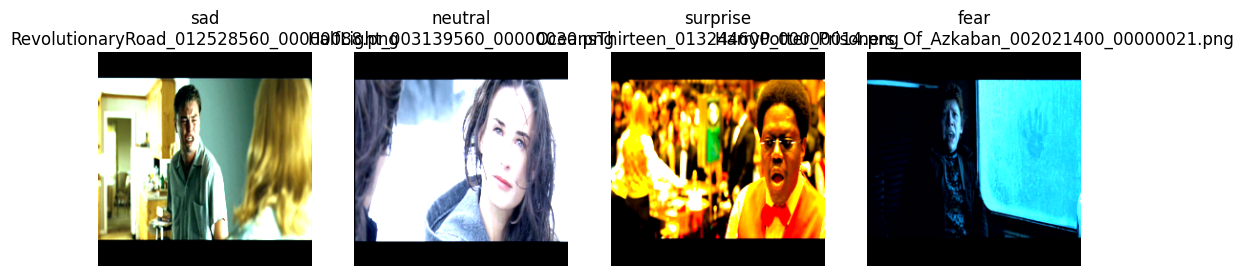

In [8]:
sfew = DatasetSFEW()
sfew_train_loader, sfew_val_loader = sfew.get_dataloader()
print(f' length of SFEW dataset : {len(sfew_train_loader.dataset)}')
show_batch(sfew_train_loader,sfew.labels,4)

## EXPW Dataset

In [9]:
#default dataloader
expw_obj  = EXPW()
expw_train_ds, expw_val_ds = expw_obj.get_dataset()
expw_train_loader, expw_val_loader = expw_obj.get_dataloader()
print(f' length of EXPW dataset : {len(expw_train_loader.dataset)} , {len(expw_train_ds)}')

Directory /content/gdrive/MyDrive/CV_FER/dataset/expwds already exists.
Directory /content/gdrive/MyDrive/CV_FER/dataset/expwds already exists.
 length of EXPW dataset : 54476 , 54476


In [15]:
next(iter(expw_train_loader))

FileNotFoundError: ignored

In [17]:
directory_path = '/content/gdrive/MyDrive/CV_FER/dataset/expwds/origin'
files = os.listdir(directory_path)
files = [file for file in files if os.path.isfile(os.path.join(directory_path, file))]
len(files)

12942

In [16]:
show_batch(expw_train_loader,expw_train_ds.labels,3)

FileNotFoundError: ignored

## Initializing Model

In [ ]:
model = DANN(num_classes=7, dropout=0.1)
model

## Training -one forward pass

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

In [ ]:
data_loader = {'source_train_loader':sfew_train_loader,
               'source_val_loader':sfew_val_loader,
               'target_train_loader':expw_train_loader,
               'target_val_loader':expw_val_loader}
model = model.to(device)
for name, data_loader in data_loader.items(): #[sfew_train_loader,sfew_val_loader,expw_train_loader,expw_val_loader]:
    print('-'*80)
    print(name)

    batch = next(iter(data_loader)) # it may be possible that some datasets have more than 2 outputs, so this strategy is safe
    images, labels = batch[0].to(device), batch[1].to(device)
    print(images.shape)

    x_labels, x_domains, x_features = model(images)

    print("input_labels\n", labels)
    print(x_labels.shape, x_domains.shape, x_features.shape)
    print("x_output_labels\n", x_labels)
    print("x_output_domains\n",x_domains)

In [ ]:
# #@title Weight Initialization

# # initializating weights using xavier normal
# def weights_init(m):
#     if isinstance(m, nn.Conv2d):
#       nn.init.xavier_normal_(m.weight)
#     elif isinstance(m, nn.Linear):
#       nn.init.xavier_normal_(m.weight)
#       nn.init.zeros_(m.bias)

# initializating weights using xavier normal
def weights_init(m):
    if isinstance(m, nn.Conv2d):
      # nn.init.xavier_normal_(m.weight)
      pass # not initialising Conv layers as they are pretrained
    elif isinstance(m, nn.Linear):
      nn.init.xavier_normal_(m.weight) # Linear layers are added on
      nn.init.zeros_(m.bias)

In [ ]:
#@title Typical Training Function with Learning rate

def train_model(model,device, data_loader, optimizer, epoch,
                class_loss_function = nn.CrossEntropyLoss() ):
    print(f'epoch = {epoch+1}...in training function')

    model.train() # setting model to training
    model.to(device)

    pbar = tqdm(data_loader) # putting the dataloader in progress bar

    processed = 0 # to understand accuracy, used in denominator
    epoch_loss = 0.0

    for batch_idx, batch in enumerate(pbar):
        images, labels = batch[0].to(device), batch[1].to(device) # batch of images and labels

        optimizer.zero_grad() # setting gradients to zero to avoid accumulation

        class_output, _ , _ = model(images) # forward pass, output = {class, domain, feature}

        class_loss = class_loss_function(class_output,labels) # Calculate Loss
        epoch_loss += class_loss.item()

        class_loss.backward() #backpropogation, creating gradients

        optimizer.step() # updating the params

        processed += len(images)
        curr_lr = optimizer.param_groups[0]['lr']

        pbar.set_description(desc= f'Loss={class_loss.item()} Batch_id={batch_idx+1} Epoch Average loss={epoch_loss/processed:0.8f} LR={curr_lr:0.6f}')

    return float("{:.8f}".format(epoch_loss/processed)),  curr_lr

In [ ]:
def get_correct_predictions(prediction, labels):
    """
    Function to return total number of correct predictions
    :param prediction: Model predictions on a given sample of data
    :param labels: Correct labels of a given sample of data
    :return: Number of correct predictions
    """
    # print(prediction)
    # print(prediction.argmax(dim=1))
    # print(f'labels = {labels}, labels.argmax ={labels.argmax(dim=1)}')
    # # print(prediction.argmax(dim=1).eq(labels))
    # # print(prediction.argmax(dim=1).eq(labels).sum())
    # # print(prediction.argmax(dim=1).eq(labels).sum().item())
    # # return prediction.argmax(dim=1).eq(labels).sum().item()
    # print(prediction.argmax(dim=1).eq(labels.argmax(dim=1)).sum())
    # print(prediction.argmax(dim=1).eq(labels.argmax(dim=1)).sum().item())
    return prediction.argmax(dim=1).eq(labels.argmax(dim=1)).sum().item()

In [ ]:


#@title Typical Test Function
def test_model(model, device, data_loader, mode= 'test',
               class_loss_function = nn.CrossEntropyLoss() ):
    model.eval() # evaluation mode

    # variables to track loss and accuracy
    test_loss = 0.0
    correct = 0

    # Disable gradient updation
    with torch.no_grad():
        # Iterate over each batch and fetch images and labels from the batch
        for batch_idx, batch in enumerate(data_loader):
            images, labels = batch[0].to(device), batch[1].to(device)

            class_output, _ , _ = model(images) # forward pass, output = {class, domain, feature}
            class_loss = class_loss_function(class_output,labels) # Calculate Loss

            test_loss += class_loss.item() # sum up batch loss

            # Sum up batch correct predictions
            correct += get_correct_predictions(class_output, labels)

    # Calculate test loss for a epoch
    test_loss /= len(data_loader.dataset)

    print('Test / Val: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(test_loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))


    return correct, test_loss



In [ ]:
runconfig = RunConfig()
device = runconfig.device

non_dann_model = DANN(num_classes=7)
non_dann_model = non_dann_model.to(device)
# non_dann_model.apply(weights_init) # initializing model, only linear layers

#learning rate
lr = float(runconfig.inital_lr)

# optimizer
optimizer = optim.SGD(non_dann_model.parameters(), lr = lr, momentum = 0.9)

# loss functions
criterion_class = (runconfig.criterion_class).to(device=device)
criterion_domain = (runconfig.criterion_domain).to(device=device)

# loss accumulation
train_losses = [] # to capture train losses over training epochs
val_losses = [] # to capture validation loss over epochs

# Epochs
EPOCHS = runconfig.NUM_EPOCHS

print('------ Training started for Non DANN Model ---- ')
print(f'starting LR : {lr}')
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)

    #Train Model
    avg_epoch_loss, curr_lr = train_model(model = non_dann_model,
                                          device = device,
                                          data_loader = sfew_train_loader,
                                          optimizer = optimizer,
                                          epoch = epoch,
                                          class_loss_function = criterion_class)
    train_losses.append(avg_epoch_loss)
    #TODO: ADD SCHEDULER

    #Validate Model
    correct, avg_epoch_val_loss = test_model(model= non_dann_model,
                                    device= device,
                                    data_loader = sfew_val_loader,
                                    class_loss_function = criterion_class
                                    )

    val_losses.append(avg_epoch_val_loss)

correct, test_loss_source = test_model(model= non_dann_model,
                                    device= device,
                                    data_loader = sfew_val_loader, # source val loader
                                    class_loss_function = criterion_class)

correct, test_loss_target = test_model(model= non_dann_model,
                                    device= device,
                                    data_loader = expw_val_loader, # target val loader
                                    class_loss_function = criterion_class)

dict_non_dann_losses_list_sfew_expw = {'train_losses' : train_losses,
                                       'val_losses': val_losses,
                                       'test_loss_source' : test_loss_source,
                                       'test_loss_target' : test_loss_target,
                                       'epoch_convergence' : 0  }




In [ ]:
print(dict_non_dann_losses_list_sfew_expw)

In [ ]:
# TODO: get this information from config
MODEL_DIR = "models"
NON_DANN_SFEW_DIR = Path(MODEL_DIR,"non_dann_sfew")
NON_DANN_SFEW_DIR

In [ ]:
model_name = "non_dann_sfew_" +str(time.strftime("%d_%m"))+ ".pt"
# dataconfig = DataConfig()
# NON_DANN_SFEW_DIR = dataconfig.NON_DANN_SFEW_DIR
if not NON_DANN_SFEW_DIR.exists():
    # Create the directory
    NON_DANN_SFEW_DIR.mkdir(parents=True, exist_ok=True)
    print(f'Directory {NON_DANN_SFEW_DIR} created successfully.')
else:
    print(f'Directory {NON_DANN_SFEW_DIR} already exists.')

torch.save(non_dann_model.state_dict(), Path(NON_DANN_SFEW_DIR,model_name))

In [ ]:
#@title Plotting Training and Validation Loss Function
def plot_loss_curves(dict_non_dann_losses_list_sfew, mode = "train_losses"):
    fig=plt.figure(figsize=(10,20))
    fig.add_subplot(5, 1, 2)
    # for embedding in dict_emb_file.keys():
    list1_to_plot= dict_non_dann_losses_list_sfew[mode]
    plt.plot(range(1,len(list1_to_plot)+1),list1_to_plot, label = 'Non DANN ' + 'SFEW')
    plt.xlabel('number of epochs', fontsize=10)
    plt.ylabel('Accuracy', fontsize=10)
    plt.legend(loc = 'upper right')
    plt.title(name + " "+mode)
    plt.show()

In [ ]:
plot_loss_curves(dict_non_dann_losses_list_sfew_expw,mode='train_losses')
plot_loss_curves(dict_non_dann_losses_list_sfew_expw,mode='val_losses')

In [ ]:
model_name = "non_dann_sfew_19_12.pt"

In [ ]:
#@title Loading NON DANN Model for DANN and DANN EWC

loaded_model_non_dann = DANN(num_classes=7) # skeleton copy
loaded_model_non_dann.load_state_dict(torch.load(Path(NON_DANN_SFEW_DIR, model_name),map_location=torch.device(device)))
model_dann = loaded_model_non_dann # saves training time - check with all
model_dann_ewc = loaded_model_non_dann # saves training time - check with all

# print(model_dann)

In [ ]:
# #checking if the models are same weights, i.e. copy has worked fine
# for p1, p2 in zip(non_dann_model.parameters(), model_dann.parameters()):
#     if p1.data.ne(p2.data).sum() > 0:
#         print ('False')
# print ('True')

In [ ]:
#@title DANN Execution (training and testing) Function without Learning rate

def execute_dann(model,device,
                     source_train_loader, source_val_loader,
                     target_train_loader, target_val_loader,
                     optimizer,
                     n_epochs, # total number of epochs (different from individual epoch)
                     class_loss_function = nn.CrossEntropyLoss(),
                     domain_loss_function = nn.BCEWithLogitsLoss() ):

    train_losses = [] # to capture train losses over training epochs
    val_losses = [] # to capture validation loss over epochs
    epoch_converge = epoch
    max_batches = min(len(source_train_loader), len(target_train_loader)) # Trying to check which is having less batches.
    model = model.to(device)
    # model.apply(weights_init) # TODO: skipping weights update - we can experimentation later on, and see if this helps
    list_alpha =[]


    for epoch_idx in range(n_epochs):
        print(f'epoch = {epoch_idx+1}...in DANN execution function')
        source_iterator = iter(source_train_loader)
        target_iterator = iter (target_train_loader)
        epoch_task_loss = 0
        epoch_domain_loss =  0
        epoch_total_loss = 0
        processed = 0

        for batch_idx in range(max_batches-1):
            p = float(batch_idx + epoch_idx * max_batches) / (n_epochs * max_batches)
            alpha = 2. / (1. + np.exp(-10 * p)) - 1
            list_alpha.append(alpha)
            alpha = torch.tensor(alpha)

            model.train() # everytime ?
            optimizer.zero_grad() # flushing out the accumulated gradients

            #---------------------Source Dataset Training ------------------------#
            source_batch = next(source_iterator)
            source_images, source_labels = source_batch[0].to(device), source_batch[1].to(device) # getting images and labels, on device
            source_class_outputs, source_domain_outputs, _ = model(source_images, alpha=alpha) # forward pass, output = {class, domain, feature}


            loss_source_class = class_loss_function(source_class_outputs, source_labels) # calculating class loss

            source_domain_inputs = torch.tensor([1., 0.]*len(source_batch[0])).view(-1,2).to(device) # Source Image == [1., 0.]

            loss_source_domain = domain_loss_function(source_domain_outputs, source_domain_inputs) # calculating domain loss

            processed += len(source_batch[0])

            #---------------------Target Dataset Training ------------------------#
            target_batch = next (target_iterator)
            target_images = target_batch[0].to(device) # getting images, on device. There are no labels for target
            _, target_domain_outputs, _ = model(target_images, alpha=alpha) # forward pass, output = {class, domain, feature}

            target_domain_inputs = torch.tensor([0., 1.]*len(source_batch[0])).view(-1,2).to(device)  # Target Image == [0., 1.]
            # print(f' target domain input shape {target_domain_inputs.shape}, output shape {target_domain_outputs.shape}')

            loss_target_domain = domain_loss_function(target_domain_outputs,target_domain_inputs)  # calculating domain loss


            #---------------------Combining Loss ------------------------#
            total_loss = loss_source_class + loss_source_domain + loss_target_domain
            total_loss.backward() #backpropogation, creating gradients
            optimizer.step() # updating the params

            epoch_task_loss += loss_source_class.item()
            epoch_domain_loss += loss_source_domain.item() + loss_target_domain.item()
            epoch_total_loss += total_loss.item()

            # after 10 batches
            if (batch_idx % 10 == 0):
                print("Epoch [{}/{}] Step [{}/{}]: loss_total={:.4f} / domain_loss_target={:.4f} / domain_loss_source={:.4f} / task_loss={:.4f} / domain_loss={:.4f} / alpha={:.4f}"
              .format(epoch_idx + 1,
                      n_epochs,
                      batch_idx + 1,
                      max_batches,
                      total_loss.item(),
                      loss_target_domain.item()
                      ,loss_source_domain.item()
                      ,loss_source_class.item()
                      ,loss_source_domain.item()+loss_source_class.item(),
                      alpha))
        # After every epoch
        avg_train_task_loss =  float("{:.6f}".format(epoch_task_loss/processed))
        train_losses.append(avg_train_task_loss)

        #TODO: Scheduler

        #Validate Model after every epoch
        correct, avg_val_task_loss = test_model(model= model,
                                                device= device,
                                                data_loader = source_val_loader,
                                                class_loss_function = class_loss_function)
        val_losses.append(avg_val_task_loss)


        #TODO: Early Stopping

    # Testing when the training is over - completed or early stopped
    correct, test_loss_source = test_model(model= model,
                            device= device,
                            data_loader = source_val_loader, # source val loader
                            class_loss_function = class_loss_function)

    correct, test_loss_target = test_model(model= model,
                            device= device,
                            data_loader = target_val_loader, # target val loader
                            class_loss_function = class_loss_function)

    dict_dann_losses = {'train_losses' : train_losses,
                        'val_losses': val_losses,
                        'test_loss_source' : test_loss_source,
                        'test_loss_target' : test_loss_target,
                        'epoch_convergence' : 0,
                        'list_alpha' : list_alpha  }

    print(f'alpha list \n {list_alpha}')
    return model, dict_dann_losses





In [ ]:
lr_dann = runconfig.inital_lr
optimizer_dann = optim.SGD(model_dann.parameters(), lr = lr_dann, momentum = 0.9)
n_epochs = runconfig.EPOCHS
print(f'------------training started for DANN Model ------------------')

dann_model_trained, dict_dann_losses = execute_dann(model=model_dann,
                                                    device=device,
                                                    source_train_loader = sfew_train_loader,
                                                    source_val_loader = sfew_val_loader,
                                                    target_train_loader = expw_train_loader,
                                                    target_val_loader = expw_val_loader,
                                                    optimizer = optimizer_dann,
                                                    n_epochs = n_epochs,
                                                    class_loss_function = runconfig.criterion_class,
                                                    domain_loss_function = runconfig.criterion_domain )

In [ ]:
dict_dann_losses

In [ ]:
plot_loss_curves(dict_dann_losses,mode='list_alpha')
